# 1. Load predictors and predictant

In [ ]:
import numpy as np

def load(inkey, outkey):
    infile = f"/docker/mnt/d/research/D2/cnn3/predictors/{inkey}.npy"
    outfile = f"/docker/mnt/d/research/D2/cnn3/predictant/class/{outkey}.npy"
    predictors = np.load(infile)
    predictant = np.load(outfile)
    return predictors, predictant

In [ ]:
tors = 'predictors_coarse_std_Apr_msot'
tant = 'pr_5x5_coarse_std_MJJASO_thailand_5'
predictors, predictant = load(tors, tant)

In [ ]:
print(predictors.shape)
print(predictant.shape)
predictant[0,0,:,:]

# 2. Pixcel dataset

- random_number identifies input/output data index.
- Then, model_number and year_number must be givern first 
- After that, 4x4 Thailand grids would be distributed to individual training dataset.
- return object of shuffle function should contain 4x4 shape

In [ ]:
def shuffle(indata, outdata, vsample, seed):
    #indata(4,42,165,24,72), outdata(42,165,4,4)
    rng = np.random.default_rng(seed)
    
    outdata = outdata.reshape(42, 165, 4, 4)
    random_number = indata.shape[1]*indata.shape[2] # 42*165
    random_index = rng.choice(random_number, random_number, replace=False)
    
    train_index = random_index[:-vsample]
    train_dct = {'model': train_index//indata.shape[2],
                 'year': train_index%indata.shape[2]}
    x_train = np.array([indata[:, m, y] for m, y in zip(
                        train_dct['model'], train_dct['year'])])
    y_train = np.array([outdata[m,y,:,:] for m, y in zip(
                        train_dct['model'], train_dct['year'])])
    
    val_index = random_index[-vsample:]
    val_dct = {'model': val_index//indata.shape[2],
               'year': val_index%indata.shape[2]}
    x_val = np.array([indata[:, m, y] for m, y in zip(
                      val_dct['model'], train_dct['year'])])
    y_val = np.array([outdata[m, y,:,:] for m, y in zip(
                      val_dct['model'], train_dct['year'])])
    # x_train(4,42*165-vsample,24,72), y_train(42*165-vsample, 4, 4) 
    return x_train, y_train, x_val, y_val, train_dct, val_dct

In [ ]:
x_train, y_train, x_val, y_val, train_dct, val_dct = shuffle(
    predictors, predictant, vsample=1000, seed=1)

In [ ]:
y_train.shape

# 3. Pixel training and save state

In [ ]:
import numpy.ma as ma

def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    f = ma.filled(z, 0)
    return f 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models 

def build_model(input_shape, output_dim):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (4,8), activation=tf.nn.relu, input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (2,4), activation=tf.nn.relu, padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (2,4), activation=tf.nn.relu, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation=tf.nn.relu))
    model.add(layers.Dense(output_dim, activation='softmax'))
    return model

- Reshape 4x4 to 16
- Train pixcel model 16 times 
- save weights with pixcel name

In [ ]:
import os
import pickle

def PixcelTrain(x_train, y_train, x_val, y_val):
    # x_train(4,tsample,24,72), y_train(tsample,4,4), x_val(4,vsample,24,72),y_val(vsample,4,4)
    # init
    class_num = 5
    lat, lon = 24, 72
    var_num = 4
    batch_size = 256
    epochs = 10
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.keras.metrics.CategoricalAccuracy()
    weightdir = f"./weights/class{class_num}_epoch{epochs}_batch{batch_size}"
    os.makedirs(weightdir, exist_ok=True)
    
    # x: input preprocessing
    x_train, x_val = mask(x_train), mask(x_val)
    x_train, x_val = x_train.transpose(0,2,3,1), x_val.transpose(0,2,3,1)
    
    # y: output preprocessing
    tsample, vsample = len(y_train), len(y_val)
    y_train, y_val = y_train.reshape(tsample, 4*4), y_val.reshape(vsample, 4*4)
    
    # pixcel loop
    for i in range(16):
        # y: output preprocessing 
        y_train_px = y_train[:,i]
        y_train_one_hot = tf.keras.utils.to_categorical(y_train_px, class_num)
        
        # model training
        model = build_model((lat, lon, var_num), class_num)
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        his = model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs)
        
        # save weights
        model.save_weights(f"{weightdir}/tmp_{i}.h5")
    
    # save state
    dct = {'x_train': x_train, 'y_train': y_train,
           'x_val': x_val, 'y_val': y_val,
           'train_dct': train_dct, 'val_dct': val_dct}
    with open('./train_val/tmp.pickle', 'wb') as f:
        pickle.dump(dct, f)

In [ ]:
PixcelTrain(x_train, y_train, x_val, y_val)

# 4. Load state and evaluate

In [47]:
def PixcelValidation():
    # init
    class_num = 5
    lat, lon = 24, 72
    var_num = 4
    batch_size = 256
    epochs = 10
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.keras.metrics.CategoricalAccuracy()
    weightdir = f"./weights/class{class_num}_epoch{epochs}_batch{batch_size}"
    
    with open('./train_val/tmp.pickle', 'rb') as f:
        data = pickle.load(f)
    x_val, y_val = data['x_val'], data['y_val']
    
    # pixcel loop
    acc = []
    for i in range(16):
        y_val_px = y_val[:,i]
        y_val_one_hot = tf.keras.utils.to_categorical(y_val_px, class_num)
        model = build_model((lat, lon, var_num), class_num)
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        model.load_weights(f"{weightdir}/tmp_{i}.h5")
        result = model.evaluate(x_val, y_val_one_hot)
        acc.append(round(result[1], 2))
        print(f"CategoricalAccuracy: {result[1]}")
    acc =  np.array(acc)
    return acc.reshape(4,4)

In [ ]:
acc = PixcelValidation()
acc.shape

# 5. View result

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

def show_class5(val_index=0, class_num=5, lat_grid=4, lon_grid=4):
    # init
    lat, lon = 24, 72
    var_num = 4
    batch_size = 256
    epochs = 10
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.keras.metrics.CategoricalAccuracy()
    weightdir = f"./weights/class{class_num}_epoch{epochs}_batch{batch_size}"
    dlt = 2
    
    with open('./train_val/tmp.pickle', 'rb') as f:
        data = pickle.load(f)
    x_val, y_val = data['x_val'], data['y_val']
    img = y_val[val_index].reshape(lat_grid, lon_grid)
    
    cmap = plt.cm.get_cmap('BrBG', class_num)
    bounds = [i - 0.5 for i in range(class_num+1)]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ticks = [i for i in range(class_num)]
    
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent= (-90, -70, 5, 25) # location = (N5-25, E90-110)
    txt_extent = (img_extent[0]+dlt, img_extent[1]-dlt, 
                  img_extent[2]+dlt, img_extent[3]-dlt)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(img, origin='upper', extent=img_extent, transform=projection,
                     norm=norm, cmap=cmap)
    cbar = fig.colorbar(mat, ax=ax, extend='both', ticks=ticks,
                        spacing='proportional', orientation='vertical')
    lat_lst = np.linspace(txt_extent[3], txt_extent[2], lat_grid)
    lon_lst = np.linspace(txt_extent[0], txt_extent[1], lon_grid)
    for i, lat in enumerate(lat_lst):
        for j, lon in enumerate(lon_lst):
            ax.text(lon, lat, img[i, j],
                    ha="center", va="center", color='black', fontsize='15')
    plt.show()

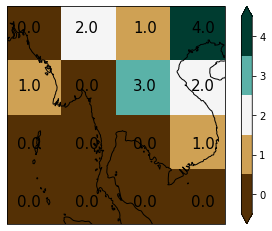

In [51]:
show_class5()

In [54]:
def view_accuracy(acc, lat_grid=4, lon_grid=4):
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent= (-90, -70, 5, 25) # location = (N5-25, E90-110)
    dlt = 2
    txt_extent = (img_extent[0]+dlt, img_extent[1]-dlt, 
                  img_extent[2]+dlt, img_extent[3]-dlt)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(acc, origin='upper', extent=img_extent, transform=projection,
                     vmin=0, vmax=1, cmap='Oranges')
    cbar = fig.colorbar(mat, ax=ax)
    
    lat_lst = np.linspace(txt_extent[3], txt_extent[2], lat_grid)
    lon_lst = np.linspace(txt_extent[0], txt_extent[1], lon_grid)
    for i, lat in enumerate(lat_lst):
        for j, lon in enumerate(lon_lst):
            ax.text(lon, lat, acc[i, j],
                    ha="center", va="center", color='black', fontsize='15')
            
    plt.show()

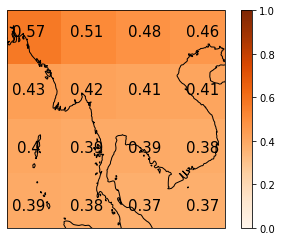

In [55]:
view_accuracy(acc)